In [1]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import time

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
import numpyro
from numpyro.contrib.nested_sampling import NestedSampler
from ripplegw.waveforms.IMRPhenomD import gen_IMRPhenomD

2024-10-07 15:47:51.901293: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
def signal_model(f, chirp_mass):
    eta, chi1, chi2, dl, tc, phic = 0.24, 0, 0, 1_000, 0, 0
    fref = 20.0
    theta = jnp.array([chirp_mass, eta, chi1, chi2, dl, tc, phic])
    return jnp.real(gen_IMRPhenomD(f, theta, fref)) * 1e24

In [3]:
def noise_model(mean = 0, variance = 1):
    return numpyro.distributions.Normal(loc = mean, scale = variance**0.5)

In [20]:
fmin = 20
fmax = 2_000
n = 100_000
f = jnp.linspace(fmin, fmax, n)

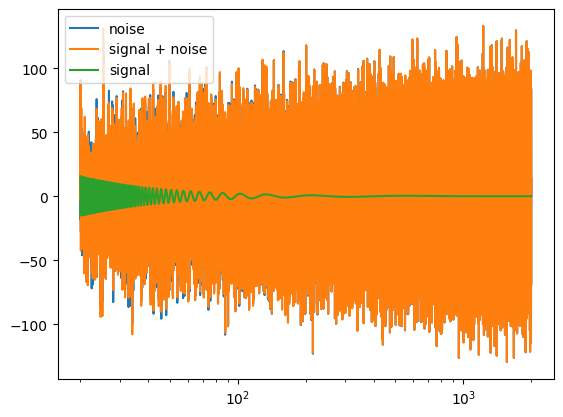

In [21]:
chirp_mass = 10
mean = 0
variance = 1_000

signal = signal_model(f, chirp_mass)
noise = noise_model(mean, variance).sample(jax.random.key(0), (n,))
data = signal + noise

plt.plot(f, noise, label = 'noise')
plt.plot(f, data, label = 'signal + noise')
plt.plot(f, signal, label = 'signal')
plt.legend()
plt.semilogx();

In [23]:
def log_lkl(data, chirp_mass):
    signal = signal_model(f, chirp_mass)
    noise = data - signal
    dist = noise_model(mean, variance)
    return (dist.log_prob(noise).sum() - dist.log_prob(data).sum())

In [24]:
m = jnp.linspace(1, 50, 1_000)
log_lkls = jax.vmap(lambda chirp_mass: log_lkl(data, chirp_mass))(m)

In [25]:
m[log_lkls.argmax()]

Array(10.025025, dtype=float32)

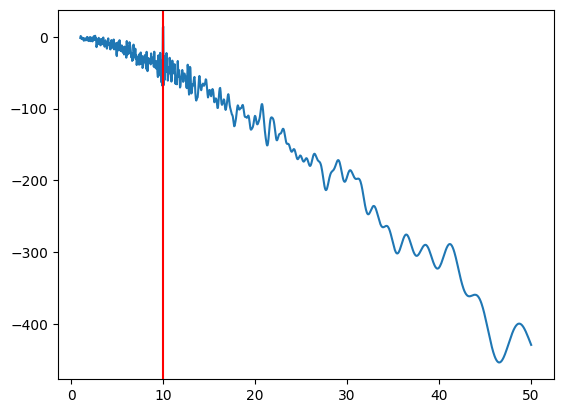

In [37]:
plt.plot(m, log_lkls);
plt.axvline(chirp_mass, c = 'r');
# plt.semilogx();

In [27]:
def model():
    chirp_mass = numpyro.sample(
        'chirp_mass', numpyro.distributions.Uniform(1, 49),
    )
    signal = signal_model(f, chirp_mass)
    # variance = numpyro.sample('variance', numpyro.distributions.Uniform(0, 10))
    with numpyro.plate('N', f.size):
        numpyro.sample(
            'noise',
            noise_model(mean = mean, variance = variance),
            obs = data - signal,
        )

In [28]:
t0 = time.time()

sampler = numpyro.infer.NUTS(
    model,
    # init_strategy = numpyro.infer.init_to_value(
    #     values = dict(chirp_mass = chirp_mass),
    # ),
)

mcmc = numpyro.infer.MCMC(
    sampler,
    num_warmup = 1_000,
    num_samples = 1_000,
)

mcmc.run(
    jax.random.key(1)
    # init_params = jnp.array([chirp_mass]),
)

print(time.time() - t0)

mcmc.print_summary()

sample: 100%|█████████████████████████████| 2000/2000 [00:25<00:00, 80.00it/s, 3 steps of size 5.44e-01. acc. prob=0.92]


29.678178071975708

                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  chirp_mass     16.18      0.02     16.18     16.16     16.22    345.30      1.00

Number of divergences: 0


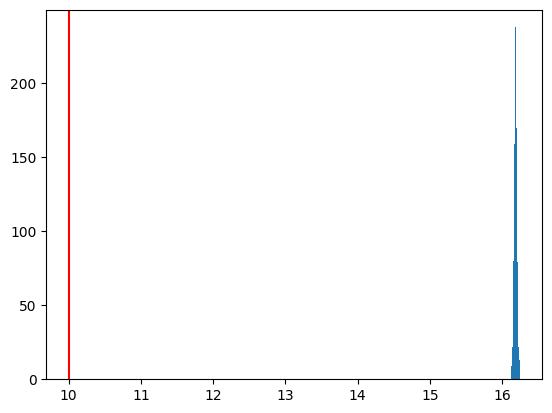

In [29]:
plt.hist(mcmc.get_samples()['chirp_mass']);
plt.axvline(chirp_mass, c = 'r');

In [62]:
t0 = time.time()

mcmc = NestedSampler(
    model,
    constructor_kwargs = dict(
        num_live_points = 500,
        # max_samples = 1e5,
        devices = jax.devices(),
    ),
    termination_kwargs = dict(dlogZ = 0.1),
)

mcmc.run(
    jax.random.key(2),
    # init_params = jnp.array([chirp_mass]),
)

print(time.time() - t0)

mcmc.print_summary()

INFO:jaxns:Number of parallel Markov-chains set to: 500
/work/submit/mmould/miniforge3/envs/gpu/lib/python3.10/site-packages/jaxns/public.py:93: UserWarning: `num_parallel_workers` is depreciated. Use `devices` instead.
  warnings.warn("`num_parallel_workers` is depreciated. Use `devices` instead.")


82.18381714820862
--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 145890
samples: 5000
phantom samples: 0
likelihood evals / sample: 29.2
phantom fraction (%): 0.0%
--------
logZ=-487238.8 +- 1.3
H=6361.75
ESS=58
--------
chirp_mass: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
chirp_mass: 10.0009 +- 0.0027 | 9.9971 / 10.0008 / 10.0044 | 10.0008 | 10.0008
--------


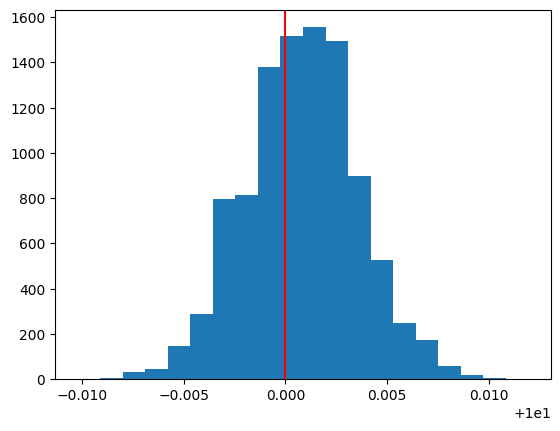

In [63]:
plt.hist(
    mcmc.get_samples(jax.random.PRNGKey(3), 10_000)['chirp_mass'],
    bins = 20,
);
plt.axvline(chirp_mass, c = 'r');